### Fourth Notebook :KerasEmbedding + BiLSTM + Attention-based + Context-aware

In [1]:
#Imporitng Libraries
import re
import numpy as np
import pandas as pd
from matplotlib.pyplot import *
import keras
from keras.models import load_model
from keras.layers import *
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences
from keras.layers import *
from keras import layers
from keras.models import Model

In [2]:
def processing(data):
    data['Utterances'] = data['Utterances'].apply(lambda x: x.lower())
    data['Utterances'] = data['Utterances'].apply(lambda x: re.sub('[^a-zA-z0-9\s]','',x))

    y = pd.get_dummies(data['Basic']).values

    return data,y

In [4]:
data = pd.read_csv('../Datasets/MRDA/mrda_data/full_set.txt', sep='|')
data.columns=['Speaker','Utterances','Basic','General','Full']
MAX_PADDING = 100
def x_value(data):
    tokenizer = Tokenizer(num_words = 5000, split=" ")
    tokenizer.fit_on_texts(data['Utterances'].values)
    x = tokenizer.texts_to_sequences(data['Utterances'].values)
    x = pad_sequences(x, padding='post', maxlen=MAX_PADDING)
    
    return x

In [5]:
train_data = pd.read_csv('../Datasets/MRDA/mrda_data/full_set.txt', sep='|')
train_data.columns=['Speaker','Utterances','Basic','General','Full']
train_data,y_train = processing(train_data)
x_train = x_value(train_data)

val_data = pd.read_csv('../Datasets/MRDA/mrda_data/train_set.txt', sep='|')
val_data.columns=['Speaker','Utterances','Basic','General','Full']
val_data,y_val = processing(val_data)
x_val = x_value(val_data)

test_data = pd.read_csv('../Datasets/MRDA/mrda_data/test_set.txt', sep='|')
test_data.columns=['Speaker','Utterances','Basic','General','Full']
test_data,y_test = processing(test_data)
x_test = x_value(test_data)

In [6]:
def prevevious_utterrance_generator(x):
    shape = x.shape 
    zeros = shape[1]
    zero_array = np.zeros((1, zeros))
    array = np.concatenate((zero_array, x))
    req_array = array[:-1]
    return req_array

In [7]:
x_train_prev = prevevious_utterrance_generator(x_train)
x_val_prev = prevevious_utterrance_generator(x_val)
x_test_prev = prevevious_utterrance_generator(x_test)

In [9]:
from keras.layers import Layer
import keras.backend as K

# Add attention layer to the deep learning network
class attention(Layer):
    def __init__(self,**kwargs):
        super(attention,self).__init__(**kwargs)

    def build(self,input_shape):
        self.W=self.add_weight(name='attention_weight', shape=(input_shape[-1],1), 
                               initializer='random_normal', trainable=True)
        self.b=self.add_weight(name='attention_bias', shape=(input_shape[1],1), 
                               initializer='zeros', trainable=True)        
        super(attention, self).build(input_shape)

    def call(self,x):
        # Alignment scores. Pass them through tanh function
        e = K.tanh(K.dot(x,self.W)+self.b)
        # Remove dimension of size 1
        e = K.squeeze(e, axis=-1)   
        # Compute the weights
        alpha = K.softmax(e)
        # Reshape to tensorFlow format
        alpha = K.expand_dims(alpha, axis=-1)
        # Compute the context vector
        context = x * alpha
        context = K.sum(context, axis=1)
        return context

In [10]:
curr_utterance_input = Input(shape=(100), name='current_utterance_input')

curr_embedding = Embedding(input_dim=5000,
                           output_dim=300,
                           input_length=100,
                           embeddings_regularizer=keras.regularizers.l2(.001))(curr_utterance_input)

curr_bilstm = Bidirectional(LSTM(units=20,
                            dropout=0.3,
                            recurrent_dropout=0.2,
                            return_sequences = True))(curr_embedding)

#attention on word level(on a single utterance)
utt_attention = attention()(curr_bilstm)

curr_output=Dense(5)(utt_attention) 


#Context of previous utterance
prev_utterance_input = Input(shape=(100,), name='previous_utterance_input')

prev_embedding =Embedding(input_dim=5000,
                          output_dim=300,
                          input_length=100,
                          embeddings_regularizer=keras.regularizers.l2(.001))(prev_utterance_input)

prev_bilstm =Bidirectional(LSTM(units=20,
                                dropout=0.3,
                                recurrent_dropout=0.2,
                                return_sequences = False))(prev_embedding)

prev_output=Dense(5)(prev_bilstm) 


concat = concatenate([curr_output, prev_output], name='Concatenate')

reshape = Reshape((-1, 10))(concat)

context_attention = attention()(reshape)

final_model_output = Dense(5, activation='softmax')(context_attention)

final_model = Model(inputs=[prev_utterance_input, curr_utterance_input],
                    outputs=final_model_output,
                    name='Final_output')

In [11]:
final_model.compile(loss='categorical_crossentropy',
                    optimizer='adam',
                    metrics=['accuracy'])
final_model.summary()

Model: "Final_output"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
current_utterance_input (InputL [(None, 100)]        0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 100, 300)     1500000     current_utterance_input[0][0]    
__________________________________________________________________________________________________
previous_utterance_input (Input [(None, 100)]        0                                            
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 100, 40)      51360       embedding_1[0][0]                
_______________________________________________________________________________________

In [12]:
early_stopping = keras.callbacks.EarlyStopping(monitor='accuracy', 
                                               mode='auto', 
                                               patience=3, 
                                               verbose=1)

In [13]:
hist = final_model.fit([x_train, x_train_prev], y_train, 
                       epochs=100, 
                       batch_size=32, 
                       verbose=1,
                       callbacks=[early_stopping],
                       validation_data=([x_val,x_val_prev], y_val) )

Epoch 1/100
2346/2346 [==============================] - 831s 351ms/step - loss: 0.7559 - accuracy: 0.7485 - val_loss: 0.7408 - val_accuracy: 0.7520
Epoch 2/100
2346/2346 [==============================] - 845s 360ms/step - loss: 0.6654 - accuracy: 0.7768 - val_loss: 0.7188 - val_accuracy: 0.7598
Epoch 3/100
2346/2346 [==============================] - 895s 382ms/step - loss: 0.6517 - accuracy: 0.7839 - val_loss: 0.7280 - val_accuracy: 0.7457
Epoch 4/100
2346/2346 [==============================] - 1083s 462ms/step - loss: 0.6453 - accuracy: 0.7864 - val_loss: 0.7064 - val_accuracy: 0.7675
Epoch 5/100
2346/2346 [==============================] - 1141s 486ms/step - loss: 0.6396 - accuracy: 0.7875 - val_loss: 0.7132 - val_accuracy: 0.7627
Epoch 6/100
2346/2346 [==============================] - 1011s 431ms/step - loss: 0.6365 - accuracy: 0.7896 - val_loss: 0.7010 - val_accuracy: 0.7711
Epoch 7/100
2346/2346 [==============================] - 1188s 506ms/step - loss: 0.6317 - accuracy: 0.

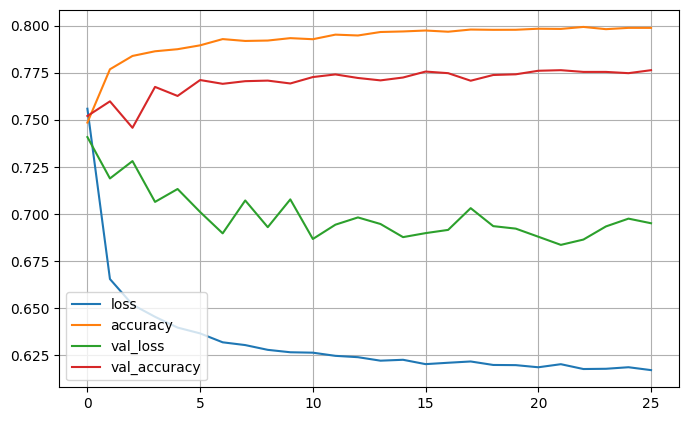

In [14]:
import matplotlib.pyplot as plt
import matplotlib

matplotlib.rcParams['figure.dpi'] = 100


def plot(history):
    pd.DataFrame(history.history).plot(figsize=(8, 5))
    plt.grid(True)
    #plt.gca().set_ylim(0,1)
    plt.show()

plot(hist)

In [15]:
final_model.evaluate([x_test, x_test_prev], y_test)

522/522 [==============================] - 113s 216ms/step - loss: 0.6550 - accuracy: 0.7846


[0.6550065279006958, 0.7846236824989319]

In [12]:
print('The model accuracy is : 0.78')

The model accuracy is : 0.78
